# Plot the output of count_events.py

In [1]:
#import python packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
%matplotlib inline
import oskar
import f2mods as f2
from positronium.constants import Ryd_Ps
from scipy.optimize import curve_fit
from scipy.constants import m_e, k, pi, micro, e
from lmfit import minimize, Parameters, report_fit
from math import floor

### Import data

In [2]:
rid = '20160315_160003'
h5 = oskar.H5Data(rid)              # data
out_dire = h5.out_dire("Count")     # output
# log 
h5.load_log()
logDF = h5.log
varDF = h5.vDF()
uDF = h5.uDF()
# count data
NAMES = ['CH_A0', 'CH_A1']
allDF = h5.load_count(NAMES, include_vars=True)

In [3]:
uDF

,DLY_EA,IR,UV,VOL_u100,VOL_u101
VID,,,,,
1,5.900000e-07,735.6035,243.2,2000,2000
2,5.900000e-07,736.4084,243.2,2000,2000
3,5.900000e-07,737.3534,243.2,2000,2000
4,5.900000e-07,738.4732,243.2,2000,2000
5,5.900000e-07,739.8138,243.2,2000,2000
6,5.900000e-07,741.4379,243.2,2000,2000
7,5.900000e-07,743.4321,243.2,2000,2000
8,5.900000e-07,745.9188,243.2,2000,2000
9,5.900000e-07,749.0765,243.2,2000,2000


In [4]:
def n_val(IR):
    return np.sqrt(-1.0/(1.0/ (IR * Ryd_Ps) - 0.25))

In [5]:
n_val(f2.rad_cal(uDF.IR.values) *1e-9)

array([ 20.00001718,  19.00002888,  18.00002259,  16.99997701,
        16.00001597,  15.00002039,  13.99998161,  12.99999067,
        12.00000196,  11.57075263,  10.99999215,  10.0000078 ,
        20.00001718,  19.00002888,  18.00002259,  16.99997701,
        16.00001597,  15.00002039,  13.99998161,  12.99999067,
        12.00000196,  11.57075263,  10.99999215,  10.0000078 ])

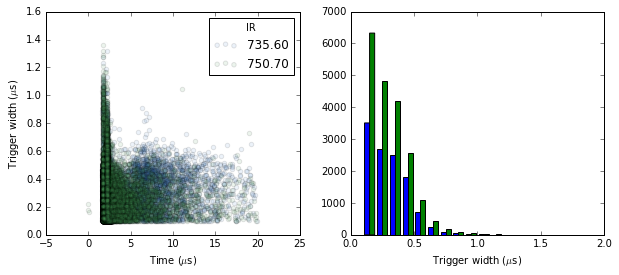

In [6]:
VIDS = [1, 10]
bin_width = 0.1
bins=np.arange(0.1, 2.0 + bin_width, bin_width)
#plot setup
hdat = []
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
for i, vid in enumerate(VIDS):
    data = allDF[(allDF[uDF.columns] == uDF.loc[vid]).all(1)]
    ax[0].scatter(data['trigger']*1e6, data['width']*1e6, alpha=0.1, c=oskar.colors[i], label='%.2f'%uDF.loc[vid, 'IR'])
    hdat.append(data['width'].values*1e6)
ax[0].legend(title='IR')
ax[1].hist(hdat, bins=bins, histtype='bar')
ax[0].set_ylabel(r"Trigger width ($\mu$s)");
ax[0].set_xlabel(r"Time ($\mu$s)");
ax[1].set_xlabel(r"Trigger width ($\mu$s)");
plt.show()

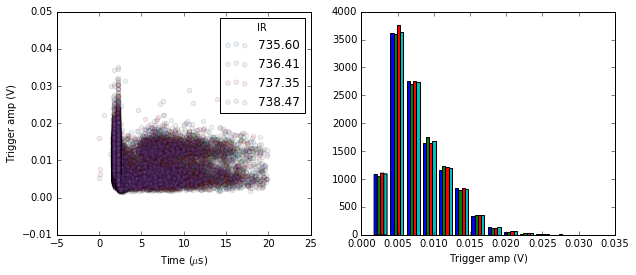

In [7]:
VIDS = [1, 2, 3, 4]
#plot setup
hdat = []
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
for i, vid in enumerate(VIDS):
    data = allDF[(allDF[uDF.columns] == uDF.loc[vid]).all(1)]
    ax[0].scatter(data['trigger']*1e6, data['amp'], alpha=0.1, c=oskar.colors[i], label='%.2f'%uDF.loc[vid, 'IR'])
    hdat.append(data['amp'].values)
ax[0].legend(title='IR')
ax[1].hist(hdat, 15, histtype='bar')
ax[0].set_ylabel(r"Trigger amp (V)");
ax[0].set_xlabel(r"Time ($\mu$s)");
ax[1].set_xlabel(r"Trigger amp (V)");
plt.show()

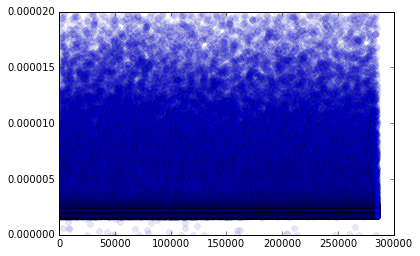

In [8]:
plt.plot(allDF.trigger.values,  'o', alpha=0.1,)

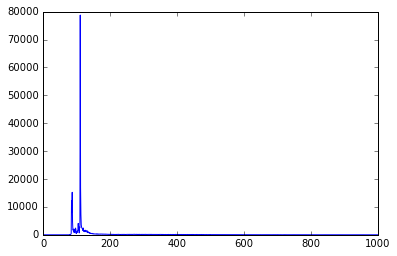

In [9]:
hs = np.histogram(allDF.trigger, 1000)
plt.plot(hs[0])

In [10]:
hs[1][:-1][hs[0] == hs[0].max()]

array([  2.20779000e-06])

In [11]:
arr = np.array([hs[1][1:][hs[0] == hs[0].max()], hs[1][:-1][hs[0] == hs[0].max()]]).flatten()
arr

array([  2.22768000e-06,   2.20779000e-06])

In [12]:
t0 = arr.mean()
t0

2.2177349999999999e-06

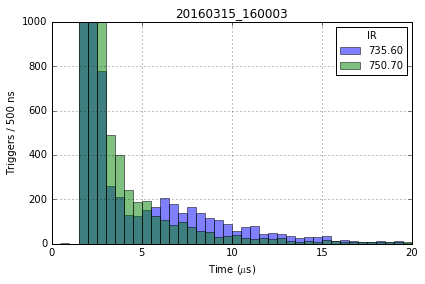

In [13]:
## plot setup
fig, ax = plt.subplots()
bin_width = 0.5
bins=np.arange(0.5,20 + bin_width, bin_width)

max_amp = 0.025
max_width = 0.5e-6

# select data
VIDS = [1, 10]
for vid in VIDS:
    # select data
    data = allDF[((allDF[uDF.columns] == uDF.loc[vid]).all(1))]
    # cut triggers
    data = data[(data['amp'] < max_amp) & (data['width'] < max_width)]
    trigs = (data['trigger'].values)*1e6
    ax.hist(trigs, bins=bins, alpha=0.5, label='%.2f'%uDF.loc[vid, 'IR'])
    
#format
plt.axhline(0, color='k', alpha=0.5)
lgd = ax.legend(loc=0, fontsize=10, title='IR')
ax.set_ylabel("Triggers / 500 ns");
ax.set_xlabel(r"Time ($\mu$s)");
ax.set_ylim(0,1000)
plt.title(rid);
ax.grid(True)

#save data
plt.tight_layout();
fileout = os.path.join(out_dire, "_".join(NAMES) + '_triggers.png')
plt.savefig(fileout, dpi=150)

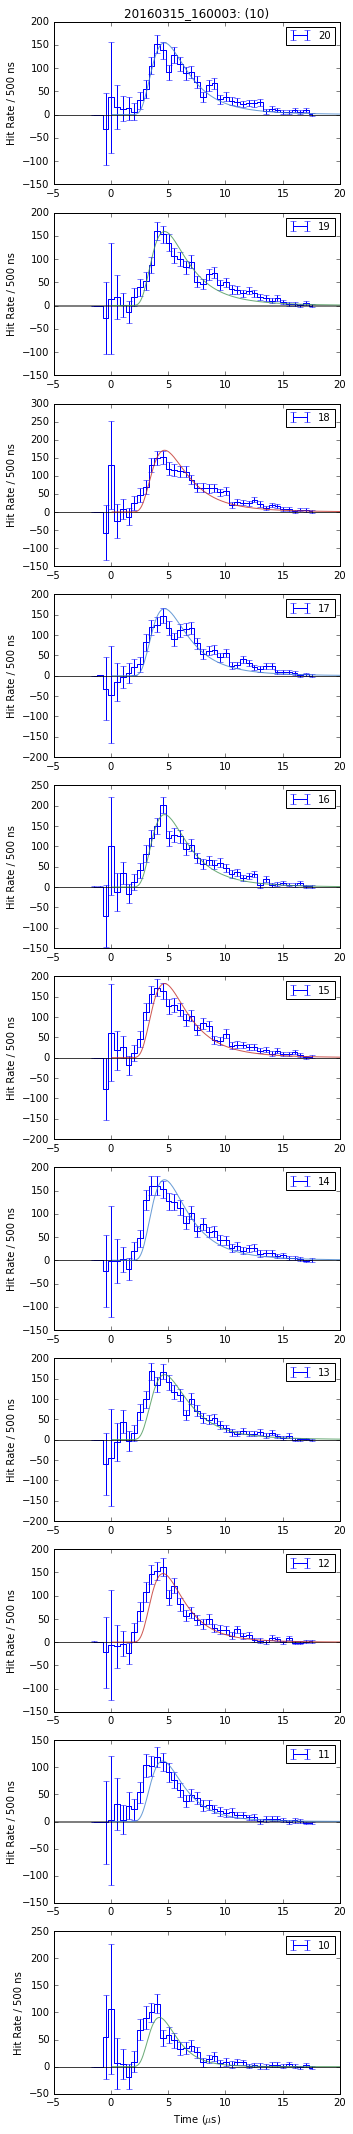

In [26]:
# histogram bins
bin_width = 0.5
bins=np.arange(0.5,20 + bin_width, bin_width)

# background
vid_off = 10
# select data
data = allDF[(allDF[uDF.columns] == uDF.loc[vid_off]).all(1)]
acq_off = logDF.loc[np.unique(data.squid.values), 'ACQUIRE'].sum()
# cut triggers
data = data[(data['amp'] < max_amp) & (data['width'] < max_width)]
trigs = (data['trigger'].values)*1e6
n_off = np.histogram(trigs, bins=bins)
x = n_off[1][:-1]+bin_width/2 - t0*1e6

# data
VIDS = [1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12]
n_rows = len(VIDS)
#plot setup
fig, ax = plt.subplots(n_rows, 1, figsize=(5,2.7*n_rows))
j = 0
hr = []
n_values = []
all_data = []
all_err = []
IR_vals = []
zero_err = 0.0005
for vid in VIDS:
    # select data
    data = allDF[(allDF[uDF.columns] == uDF.loc[vid]).all(1)]
    acq_on = logDF.loc[np.unique(data.squid.values), 'ACQUIRE'].sum()
    # cut triggers
    data = data[(data['amp'] < max_amp) & (data['width'] < max_width)]
    trigs = (data['trigger'].values)*1e6
    n_on = np.histogram(trigs, bins=bins)
    # normalise and subtract background
    y =  np.subtract(n_on[0], n_off[0] *acq_on/ acq_off)
    yerr  = np.add(np.sqrt(n_on[0]), np.sqrt(n_off[0]) * acq_on/ acq_off)
    n = (round(n_val(f2.rad_cal(uDF.loc[vid].IR) * 1e-9)))
    n_values.append(n)
    ax[j].errorbar(x, y, yerr=yerr, drawstyle='steps-mid', label='%d'%n)
    ax[j].legend(loc=0, fontsize=10)
    ax[j].set_ylabel("Hit Rate / 500 ns")
    ax[j].axhline(0, color='k', alpha=0.5)
    hr.append(y[4:].sum())
    IR_vals.append(name)
    # collect data
    all_data.append(y)
    fear = np.array([zero_err if ye == 0 else ye for ye in yerr])
    all_err.append(fear)
    ax[j].axhline(0.02*j, color='k', alpha=0.5)
    j = j + 1

# format
ax[-1].set_xlabel(r"Time ($\mu$s)");
ax[0].set_title(rid + ': (' + str(vid_off) + ')');

all_data = np.array(all_data)
all_err = np.array(all_err)
assert(all_data.shape) == np.shape(all_data)
    
## Global Fitting

M = 2*m_e
d = 1.24

def f(x, A, tau, T):
    v = d/ x
    vbar = np.sqrt(np.divide(k * T, M))
    return np.divide(v, x) * A * np.exp(-x/(tau*micro)) * np.divide(np.power(v, 3), 2.0 * vbar**4) * np.exp(np.divide(-np.power(v,2), 2 * vbar**2))

def dataset(params, i, x):
    A = params['A_%i' % (i+1)].value
    tau = params['tau_%i' % (i+1)].value
    T = params['T_%i' % (i+1)].value
    return f(x, A, tau, T)

def objective(params, x, data, err):
    ndata, nx = data.shape
    resid = 0.0*data[:]
    weighted = 0.0*data[:]
    for i in range(ndata):
        resid[i, :] = data[i, :] - dataset(params, i, x)
        weighted[i, :] = (data[i, :] - dataset(params, i, x))/ err[i,:]
    return weighted.flatten()

fit_params = Parameters()
for iy, y in enumerate(all_data):
    fit_params.add( 'A_%i' % (iy+1), value=1e-7, min=1e-18,  max=1e-2)
    fit_params.add( 'tau_%i' % (iy+1), value=1, min=0.1,  max=200)
    fit_params.add( 'T_%i' % (iy+1), value=3000, min=100, max=7000)

# but now constrain decay and T
for iy in range(len(all_data)+1)[2:]:
    fit_params['T_%i' % iy].expr='T_1'

# run the global fit to all the data sets
fit = minimize(objective, fit_params, args=(x*micro, all_data, all_err))

for kk in range(11):
    xl = np.linspace(0, 20, 201)
    y_fit = dataset(fit.params, kk, xl * micro)
    ax[kk].plot(xl, y_fit + 0.01*kk, '-', c=oskar.colors[kk%3], alpha=0.8)

# save data
plt.tight_layout();
fileout = os.path.join(out_dire, "_".join(NAMES) + '_fitting.png')
plt.savefig(fileout, dpi=150)
plt.show()

In [27]:
report_fit(fit)

[[Fit Statistics]]
    # function evals   = 16240
    # data points      = 429
    # variables        = 23
    chi-square         = 737.062
    reduced chi-square = 1.815
[[Variables]]
    A_1:      0.00072149 +/- 0        (0.00%) (init= 1e-07)
    tau_1:    200        +/- 0        (0.00%) (init= 1)
    T_1:      1846.32048 +/- 0        (0.00%) (init= 3000)
    A_2:      0.00074494 +/- 0        (0.00%) (init= 1e-07)
    tau_2:    200        +/- 0        (0.00%) (init= 1)
    T_2:      1846.32048 +/- 0        (0.00%)  == 'T_1'
    A_3:      0.00079832 +/- 0        (0.00%) (init= 1e-07)
    tau_3:    199.545813 +/- 0        (0.00%) (init= 1)
    T_3:      1846.32048 +/- 0        (0.00%)  == 'T_1'
    A_4:      0.00077162 +/- 0        (0.00%) (init= 1e-07)
    tau_4:    200        +/- 0        (0.00%) (init= 1)
    T_4:      1846.32048 +/- 0        (0.00%)  == 'T_1'
    A_5:      0.00083322 +/- 0        (0.00%) (init= 1e-07)
    tau_5:    199.999969 +/- 0        (0.00%) (init= 1)
    T_5:

In [28]:
from positronium import decay

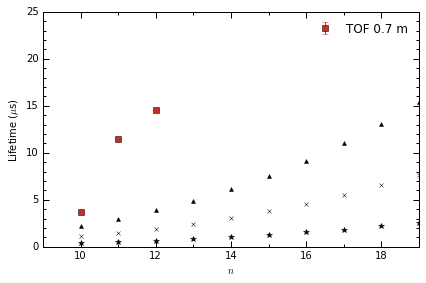

In [32]:
tau_vals = [fit.params.get('tau_'+str(kk+1)).value for kk in range(11)]
tau_errs = [fit.params.get('tau_'+str(kk+1)).stderr for kk in range(11)]

#fit

def h(n, *p):
    alpha = p
    f = alpha * n**4
    return f

# guess
#p0 = [10]
#xf = np.arange(10, 22, 0.2)
# fit
#print(n_vals[2:])
#coeff, cov = curve_fit(h, n_values[:-2], tau_vals[:-2], p0=p0, sigma=tau_errs[:-2])
#y3 = h(xf, *coeff)

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(n_values, 1e6* decay.radiative(n_values, 1), '*', c='k', ms=6.0)
ax.plot(n_values, 1e6* decay.radiative(n_values, 2), 'x', c='k', ms=4.0)
ax.plot(n_values, 1e6* decay.radiative(n_values, 3), '^', c='k', ms=4.0)
ax.errorbar(n_values, tau_vals, yerr=tau_errs, fmt='s', c=oskar.colors[2], label='TOF 0.7 m')
#ax.errorbar([12, 18], [3.01485721, 9.26889887], yerr=[0.261626, 1.073776], fmt='o', c=oskar.colors[0], label='TOF 1.2 m')
#plt.plot(xf, y3, c=oskar.colors[0], ls='--', label = r'$y = $ %.2e $n^4$'%coeff[0])
# format
plt.axhline(0, color='k', alpha=0.5)
ax.legend(loc=0, frameon=False, fontsize=12, numpoints = 1)
ax.set_ylabel(r"Lifetime ($\mu$s)");
ax.set_xlabel(r"$n$");
ax.set_ylim([0, 25])
ax.set_xlim([9, 19])

majorLocator = MultipleLocator(2)
minorLocator = MultipleLocator(1)
ax.xaxis.set_major_locator(majorLocator)
ax.xaxis.set_minor_locator(minorLocator)

majorLocator = MultipleLocator(5)
minorLocator = MultipleLocator(1)
ax.yaxis.set_major_locator(majorLocator)
ax.yaxis.set_minor_locator(minorLocator)

ax.tick_params(axis='both', which='major', length=6, width=1)
ax.tick_params(axis='both', which='minor', length=3, width=1)

# save data
plt.tight_layout();
fileout = os.path.join("C:\Users\Adam\Dropbox\Documents\Articles\Rydberg_PRA",  'TOF_long_n_fit.pdf')
plt.savefig(fileout, dpi=600, bbox_inches='tight')
plt.show()